# Importing Packages

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
import imageio

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from customMetrics import dice_loss, dice_coef, iou, jaccard_coef, jaccard_loss

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
from patchify import patchify, unpatchify

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Loading Utils Functions

In [6]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [7]:
def read_image(path):
    src = cv2.imread(path, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    x = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    
    top, bottom = [28] * 2
    left, right = [37,38]
    
    x = cv2.copyMakeBorder(x, top, bottom, left, right, cv2.BORDER_CONSTANT, value= 0)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

In [8]:
def read_gt(path):
    x = imageio.mimread(path)[0]  ## (128, 128)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

In [9]:
def load_data(path):
    x = sorted(glob(os.path.join(path, "images", "*.tif")))
    y = sorted(glob(os.path.join(path, "1st_manual", "*.gif")))
    return x, y

In [10]:
def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255

    cat_images = np.concatenate([ori_y, line, y_pred], axis=1)
    
    cv2.imwrite(save_image_path, cat_images)

In [11]:
def save_tests(y_pred, save_image_path):

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255


    cv2.imwrite(save_image_path, y_pred)

In [12]:
def get_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    sen = tp/(tp+fn)
    spe = tn/(tn+fp) 
    return sen, spe

# Setting The Environment

In [13]:
H = 584
W = 565

In [14]:
data_path = "D:\\Data sets\\DRIVE"

In [15]:
""" Save the results in this folder """
create_dir("results")

In [19]:
""" Load the model """
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss, 'jaccard_coef': jaccard_coef, 'jaccard_loss' : jaccard_loss}):
    model = tf.keras.models.load_model("modelDir/model128_basicJac.h5")


In [20]:
""" Load the dataset """
traindataset_path = os.path.join(data_path,"training")
train_x, train_y = load_data(traindataset_path)

testdataset_path = os.path.join(data_path,"test")
test_x, test_y = load_data(testdataset_path)

In [21]:
testdataset_path,len(test_x)

('D:\\Data sets\\DRIVE\\test', 20)

In [23]:
traindataset_path,len(train_x)

('D:\\Data sets\\DRIVE\\training', 20)

In [24]:
from matplotlib import pyplot as plt

# Training Results

In [23]:
""" Make the prediction and calculate the metrics values """
SCORE = []

for x, y in tqdm(zip(train_x, train_y), total=len(train_x)):
    
    """ Extracting name """
    name = x.split("\\")[-1].split(".")[0]
    print(name)
    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_gt(y)
    
    print(ori_x.shape, ori_y.shape)
    
    patches_img = patchify(x, (128, 128,3), step=128)
    
    pred_patches = []
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):        
            single_patch_img = patches_img[i,j,:,:][0]
#             print(single_patch_img.shape)
            
            """ Prediction """
            y_pred = model.predict(np.expand_dims(single_patch_img, axis=0))[0]
            y_pred = y_pred > 0.5
            y_pred = y_pred.astype(np.int32)
            y_pred = np.squeeze(y_pred, axis=-1)
            
            pred_patches.append(y_pred)
    pred_patches_reshaped = np.reshape(pred_patches, (5, 5, 128,128) )
    reconstructed_image = unpatchify(pred_patches_reshaped, (640,640))
    
    final_y_pred = reconstructed_image[28:-28,37:-38]
    print(final_y_pred.shape)
#     plt.imshow(final_y_pred, cmap='gray')
    
    
    """ Saving the images """
    save_image_path = f"results\\{name}Train.png"
    print(save_image_path)

#     save_results(ori_x, ori_y, final_y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    final_y_pred = final_y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, final_y_pred)
    f1_value = f1_score(y, final_y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, final_y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, final_y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, final_y_pred, labels=[0, 1], average="binary")
    
    cm = confusion_matrix(y, final_y_pred)
    sensitivity, specificity = get_metrics(cm)
    
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, sensitivity, specificity])

  0%|                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

21_training
(640, 640, 3) (584, 565)
(584, 565)
results\21_trainingTrain.png


  5%|███████▎                                                                                                                                         | 1/20 [00:32<10:09, 32.10s/it]

22_training
(640, 640, 3) (584, 565)
(584, 565)
results\22_trainingTrain.png


 10%|██████████████▌                                                                                                                                  | 2/20 [00:34<04:24, 14.70s/it]

23_training
(640, 640, 3) (584, 565)
(584, 565)
results\23_trainingTrain.png


 15%|█████████████████████▊                                                                                                                           | 3/20 [00:36<02:33,  9.04s/it]

24_training
(640, 640, 3) (584, 565)
(584, 565)
results\24_trainingTrain.png


 20%|█████████████████████████████                                                                                                                    | 4/20 [00:39<01:42,  6.42s/it]

25_training
(640, 640, 3) (584, 565)
(584, 565)
results\25_trainingTrain.png


 25%|████████████████████████████████████▎                                                                                                            | 5/20 [00:41<01:14,  4.95s/it]

26_training
(640, 640, 3) (584, 565)
(584, 565)
results\26_trainingTrain.png


 30%|███████████████████████████████████████████▌                                                                                                     | 6/20 [00:44<00:57,  4.08s/it]

27_training
(640, 640, 3) (584, 565)
(584, 565)
results\27_trainingTrain.png


 35%|██████████████████████████████████████████████████▊                                                                                              | 7/20 [00:46<00:45,  3.51s/it]

28_training
(640, 640, 3) (584, 565)
(584, 565)
results\28_trainingTrain.png


 40%|██████████████████████████████████████████████████████████                                                                                       | 8/20 [00:48<00:38,  3.17s/it]

29_training
(640, 640, 3) (584, 565)
(584, 565)
results\29_trainingTrain.png


 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 9/20 [00:51<00:32,  2.95s/it]

30_training
(640, 640, 3) (584, 565)
(584, 565)
results\30_trainingTrain.png


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 10/20 [00:53<00:27,  2.75s/it]

31_training
(640, 640, 3) (584, 565)
(584, 565)
results\31_trainingTrain.png


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 11/20 [00:56<00:24,  2.67s/it]

32_training
(640, 640, 3) (584, 565)
(584, 565)
results\32_trainingTrain.png


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12/20 [00:58<00:21,  2.63s/it]

33_training
(640, 640, 3) (584, 565)
(584, 565)
results\33_trainingTrain.png


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13/20 [01:01<00:18,  2.65s/it]

34_training
(640, 640, 3) (584, 565)
(584, 565)
results\34_trainingTrain.png


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14/20 [01:03<00:15,  2.52s/it]

35_training
(640, 640, 3) (584, 565)
(584, 565)
results\35_trainingTrain.png


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15/20 [01:05<00:12,  2.45s/it]

36_training
(640, 640, 3) (584, 565)
(584, 565)
results\36_trainingTrain.png


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16/20 [01:08<00:09,  2.42s/it]

37_training
(640, 640, 3) (584, 565)
(584, 565)
results\37_trainingTrain.png


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 17/20 [01:11<00:07,  2.66s/it]

38_training
(640, 640, 3) (584, 565)
(584, 565)
results\38_trainingTrain.png


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 18/20 [01:13<00:05,  2.61s/it]

39_training
(640, 640, 3) (584, 565)
(584, 565)
results\39_trainingTrain.png


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 19/20 [01:16<00:02,  2.62s/it]

40_training
(640, 640, 3) (584, 565)
(584, 565)
results\40_trainingTrain.png


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.95s/it]


In [24]:
SCORE

[['21_training',
  0.9711328645896472,
  0.8009612370703166,
  0.6680027884280237,
  0.7772325411631114,
  0.8261844203991896,
  0.7772325411631114,
  0.9867934045633504],
 ['22_training',
  0.9705449145350952,
  0.8199618398384677,
  0.6948604439421054,
  0.7424603307725854,
  0.9155290808306445,
  0.7424603307725854,
  0.9931967576319919],
 ['23_training',
  0.9788368287065099,
  0.8265222467890592,
  0.7043356761791854,
  0.765778207429913,
  0.897733405288721,
  0.765778207429913,
  0.9938521332610946],
 ['24_training',
  0.9644290216996,
  0.8267115501026118,
  0.7046106608949514,
  0.7323497868110597,
  0.9489865093891939,
  0.7323497868110597,
  0.9948411378975838],
 ['25_training',
  0.9500939507819129,
  0.6663559923006788,
  0.499650572756829,
  0.519245950298399,
  0.9297749632477667,
  0.519245950298399,
  0.9958362806789344],
 ['26_training',
  0.9618014304764214,
  0.7294001459916698,
  0.5740596803082019,
  0.616073695281616,
  0.8938174164693502,
  0.616073695281616,
  

In [25]:

stat_df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Sensitivity", "Specificity"])
stat_df

,Image,Acc,F1,Jaccard,Recall,Precision,Sensitivity,Specificity
0,21_training,0.971133,0.800961,0.668003,0.777233,0.826184,0.777233,0.986793
1,22_training,0.970545,0.819962,0.694860,0.742460,0.915529,0.742460,0.993197
2,23_training,0.978837,0.826522,0.704336,0.765778,0.897733,0.765778,0.993852
3,24_training,0.964429,0.826712,0.704611,0.732350,0.948987,0.732350,0.994841
4,25_training,0.950094,0.666356,0.499651,0.519246,0.929775,0.519246,0.995836
5,26_training,0.961801,0.729400,0.574060,0.616074,0.893817,0.616074,0.993326
6,27_training,0.972509,0.834679,0.716265,0.787638,0.887696,0.787638,0.990372
7,28_training,0.971760,0.847456,0.735292,0.803122,0.896971,0.803122,0.990015
8,29_training,0.959768,0.760357,0.613368,0.758892,0.761829,0.758892,0.978214
9,30_training,0.963332,0.719937,0.562423,0.600796,0.898019,0.600796,0.994192


In [26]:
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")
print(f"Sensitivity: {score[5]:0.5f}")
print(f"Specificity: {score[6]:0.5f}")


Accuracy: 0.96910
F1: 0.80440
Jaccard: 0.67591
Recall: 0.75100
Precision: 0.87746
Sensitivity: 0.75100
Specificity: 0.98976


In [27]:
rows = ["Accuracy", "F1", "Jaccard", "Recall", "Precision", "Sensitivity", "Specificity"]

In [28]:
df = pd.DataFrame(
    {'Metrics': rows,
     'Model_128_basic': score,
    })
df

,Metrics,Model_128_basic
0,Accuracy,0.969104
1,F1,0.804396
2,Jaccard,0.675909
3,Recall,0.751004
4,Precision,0.877456
5,Sensitivity,0.751004
6,Specificity,0.989762


In [29]:
""" Saving """
df.to_csv("score/train.csv", index=False)

In [29]:
import seaborn as sns

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

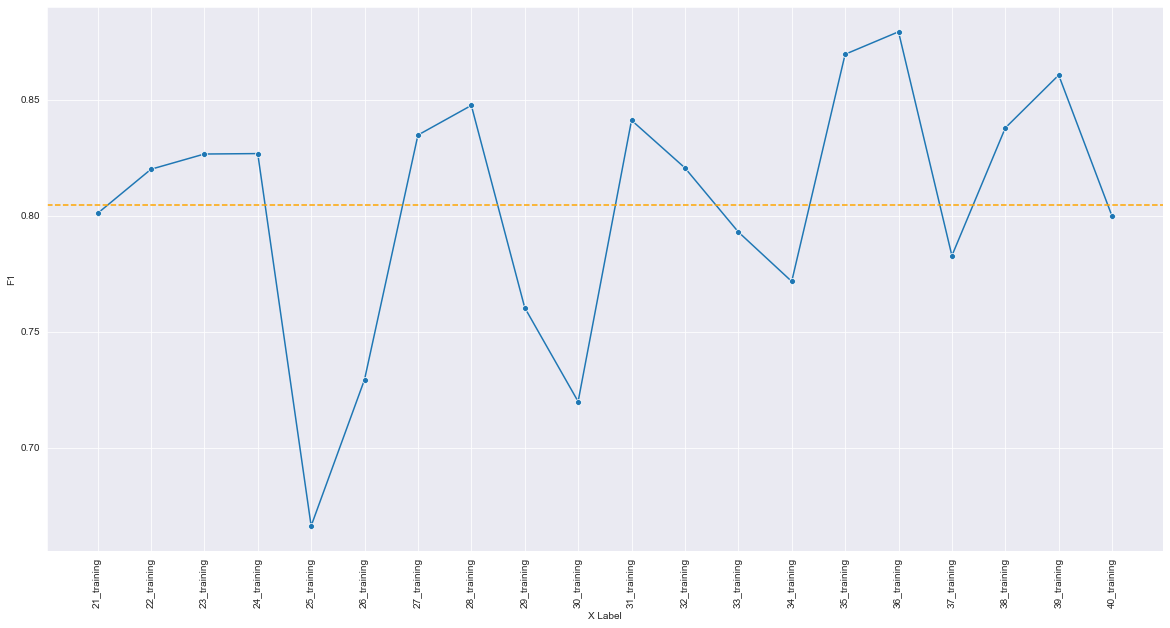

In [32]:
plt.figure(figsize=(20, 10))
sns.set_style("darkgrid")
ax = sns.lineplot(data=stat_df, x="Image", y="F1", marker = "o")
ax.axhline(stat_df["F1"].mean(), color="orange", linestyle="--")
ax.set(xlabel="X Label", ylabel = "F1")
plt.setp(ax.get_xticklabels(), rotation=90)


# Test Results

In [25]:
""" Make the prediction and calculate the metrics values """
SCORE = []

for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    
    """ Extracting name """
    name = x.split("\\")[-1].split(".")[0]
    print(name)
    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_gt(y)
    
    print(ori_x.shape, ori_y.shape)
    
    patches_img = patchify(x, (128, 128,3), step=128)
    
    pred_patches = []
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):        
            single_patch_img = patches_img[i,j,:,:][0]
#             print(single_patch_img.shape)
            
            """ Prediction """
            y_pred = model.predict(np.expand_dims(single_patch_img, axis=0))[0]
            y_pred = y_pred > 0.5
            y_pred = y_pred.astype(np.int32)
            y_pred = np.squeeze(y_pred, axis=-1)
            
            pred_patches.append(y_pred)
    pred_patches_reshaped = np.reshape(pred_patches, (5, 5, 128,128) )
    reconstructed_image = unpatchify(pred_patches_reshaped, (640,640))
    
    final_y_pred = reconstructed_image[28:-28,37:-38]
    print(final_y_pred.shape)
#     plt.imshow(final_y_pred, cmap='gray')
    
    
    """ Saving the images """
    save_image_path = f"results\\{name}Test.png"
    print(save_image_path)

    save_results(ori_x, ori_y, final_y_pred, save_image_path)
    save_tests(final_y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    final_y_pred = final_y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, final_y_pred)
    f1_value = f1_score(y, final_y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, final_y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, final_y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, final_y_pred, labels=[0, 1], average="binary")
    
    cm = confusion_matrix(y, final_y_pred)
    sensitivity, specificity = get_metrics(cm)
    
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, sensitivity, specificity])

  0%|                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

01_test
(640, 640, 3) (584, 565)
(584, 565)
results\01_testTest.png


  5%|███████▎                                                                                                                                         | 1/20 [00:26<08:32, 26.99s/it]

02_test
(640, 640, 3) (584, 565)
(584, 565)
results\02_testTest.png


 10%|██████████████▌                                                                                                                                  | 2/20 [00:29<03:45, 12.51s/it]

03_test
(640, 640, 3) (584, 565)
(584, 565)
results\03_testTest.png


 15%|█████████████████████▊                                                                                                                           | 3/20 [00:31<02:14,  7.90s/it]

04_test
(640, 640, 3) (584, 565)
(584, 565)
results\04_testTest.png


 20%|█████████████████████████████                                                                                                                    | 4/20 [00:34<01:30,  5.67s/it]

05_test
(640, 640, 3) (584, 565)
(584, 565)
results\05_testTest.png


 25%|████████████████████████████████████▎                                                                                                            | 5/20 [00:36<01:06,  4.46s/it]

06_test
(640, 640, 3) (584, 565)
(584, 565)
results\06_testTest.png


 30%|███████████████████████████████████████████▌                                                                                                     | 6/20 [00:38<00:51,  3.68s/it]

07_test
(640, 640, 3) (584, 565)
(584, 565)
results\07_testTest.png


 35%|██████████████████████████████████████████████████▊                                                                                              | 7/20 [00:40<00:41,  3.18s/it]

08_test
(640, 640, 3) (584, 565)
(584, 565)
results\08_testTest.png


 40%|██████████████████████████████████████████████████████████                                                                                       | 8/20 [00:42<00:34,  2.87s/it]

09_test
(640, 640, 3) (584, 565)
(584, 565)
results\09_testTest.png


 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 9/20 [00:45<00:29,  2.71s/it]

10_test
(640, 640, 3) (584, 565)
(584, 565)
results\10_testTest.png


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 10/20 [00:47<00:25,  2.56s/it]

11_test
(640, 640, 3) (584, 565)
(584, 565)
results\11_testTest.png


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 11/20 [00:49<00:22,  2.45s/it]

12_test
(640, 640, 3) (584, 565)
(584, 565)
results\12_testTest.png


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12/20 [00:51<00:19,  2.38s/it]

13_test
(640, 640, 3) (584, 565)
(584, 565)
results\13_testTest.png


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13/20 [00:54<00:16,  2.32s/it]

14_test
(640, 640, 3) (584, 565)
(584, 565)
results\14_testTest.png


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14/20 [00:56<00:14,  2.37s/it]

15_test
(640, 640, 3) (584, 565)
(584, 565)
results\15_testTest.png


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15/20 [00:58<00:11,  2.32s/it]

16_test
(640, 640, 3) (584, 565)
(584, 565)
results\16_testTest.png


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16/20 [01:01<00:09,  2.39s/it]

17_test
(640, 640, 3) (584, 565)
(584, 565)
results\17_testTest.png


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 17/20 [01:03<00:07,  2.39s/it]

18_test
(640, 640, 3) (584, 565)
(584, 565)
results\18_testTest.png


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 18/20 [01:05<00:04,  2.33s/it]

19_test
(640, 640, 3) (584, 565)
(584, 565)
results\19_testTest.png


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 19/20 [01:08<00:02,  2.37s/it]

20_test
(640, 640, 3) (584, 565)
(584, 565)
results\20_testTest.png


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:11<00:00,  3.55s/it]


In [26]:
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")
print(f"Sensitivity: {score[5]:0.5f}")
print(f"Specificity: {score[6]:0.5f}")

Accuracy: 0.95799
F1: 0.75156
Jaccard: 0.60353
Recall: 0.73677
Precision: 0.77904
Sensitivity: 0.73677
Specificity: 0.97950


In [27]:
test_df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Sensitivity", "Specificity"])
test_df

,Image,Acc,F1,Jaccard,Recall,Precision,Sensitivity,Specificity
0,01_test,0.957058,0.775092,0.632775,0.829314,0.727525,0.829314,0.969573
1,02_test,0.961947,0.808895,0.679113,0.786416,0.832696,0.786416,0.981973
2,03_test,0.940362,0.616054,0.445143,0.479950,0.859905,0.479950,0.991342
3,04_test,0.962483,0.791981,0.655603,0.776339,0.808266,0.776339,0.981342
4,05_test,0.959983,0.760684,0.613794,0.678863,0.864933,0.678863,0.989042
5,06_test,0.954695,0.738201,0.585038,0.656246,0.843546,0.656246,0.986876
6,07_test,0.957952,0.766502,0.621405,0.755240,0.778104,0.755240,0.978339
7,08_test,0.956431,0.724724,0.568288,0.666596,0.793958,0.666596,0.983715
8,09_test,0.959989,0.721077,0.563815,0.638159,0.828760,0.638159,0.988371
9,10_test,0.960471,0.761078,0.614306,0.764987,0.757208,0.764987,0.978002


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

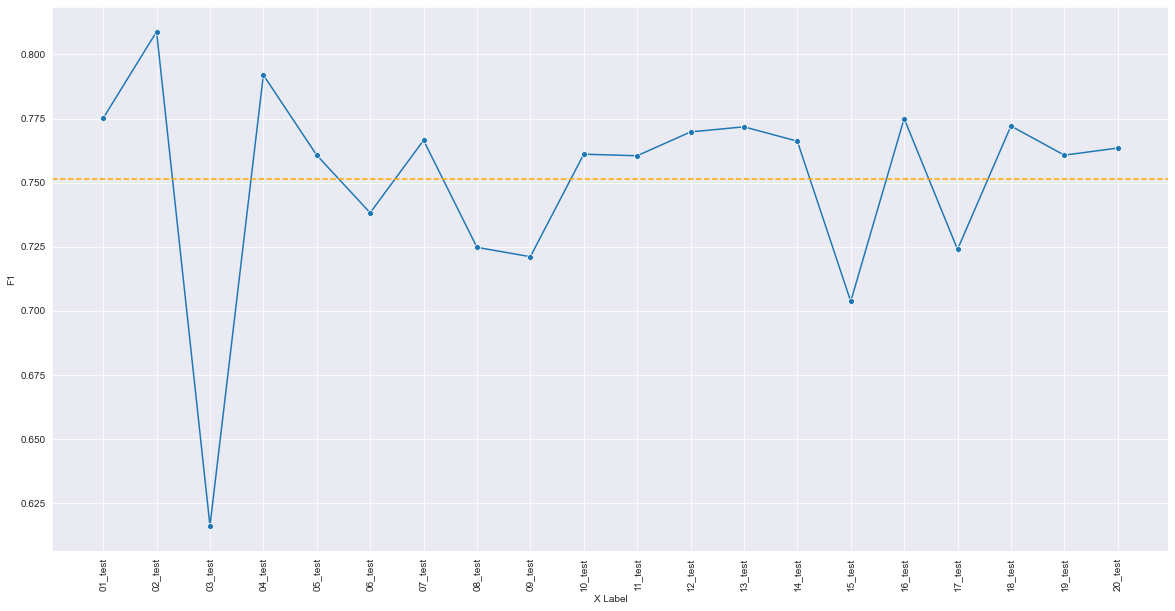

In [31]:
plt.figure(figsize=(20, 10))
sns.set_style("darkgrid")
ax = sns.lineplot(data=test_df, x="Image", y="F1", marker = "o")
ax.axhline(test_df["F1"].mean(), color="orange", linestyle="--")
ax.set(xlabel="X Label", ylabel = "F1")
plt.setp(ax.get_xticklabels(), rotation=90)
